In [1]:
from google.colab import files

#Upload Model
print("Upload your model (.keras or .h5 format)")
model_file = files.upload()  # Upload the model file
model_filename = list(model_file.keys())[0]

Upload your model (.keras or .h5 format)


Saving seg_model.keras to seg_model.keras


In [2]:
print("Upload up to 4 images for prediction")
image_files = files.upload()  # Upload up to 4 images
image_filenames = list(image_files.keys())

Upload up to 4 images for prediction


Saving 01c2e8d54.jpg to 01c2e8d54.jpg
Saving 02ce88ea5.jpg to 02ce88ea5.jpg
Saving 008c79db7.jpg to 008c79db7.jpg
Saving 018d23aea.jpg to 018d23aea.jpg


In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import register_keras_serializable # Import register_keras_serializable

# IoU Metric
@register_keras_serializable()
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    return tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)

# IoU Loss
@register_keras_serializable()
def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(iou, axis=0)

# IoU + BCE Loss
@register_keras_serializable()
def iou_p_bce(y_true, y_pred, alpha=1e-3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    iou = iou_loss(y_true, y_pred, smooth)
    bce = binary_crossentropy(y_true, y_pred)
    return bce + alpha * iou

# F1 Metric
@register_keras_serializable()
def f1_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    precision = intersection / (tf.reduce_sum(y_pred, axis=[1, 2, 3]) + smooth)
    recall = intersection / (tf.reduce_sum(y_true, axis=[1, 2, 3]) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return tf.reduce_mean(f1, axis=0)

In [27]:
customObjects = {
    'IOU_Metric': iou_metric,
    'F1_Metric': f1_metric,
    'IOU_Loss': iou_loss,
    'IOU_BCE': iou_p_bce,
}

In [28]:
# Load the model
print("Loading model...")
model = load_model(model_filename, custom_objects=customObjects)
print("Model loaded successfully!")

Loading model...
Model loaded successfully!


In [29]:
# File paths for your 4 images
image_paths = [
    "/content/008c79db7.jpg",
    "/content/018d23aea.jpg",
    "/content/01c2e8d54.jpg",
    "/content/02ce88ea5.jpg"
]

In [30]:
def preprocess_image(image_path, target_size=(768, 768)):
    """
    Preprocesses an image for the model.
    Adds batch size of 4 with padding if needed.
    """
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Create a batch of 4 images
batch = []
for image_path in image_paths:
    batch.append(preprocess_image(image_path))

while len(batch) < 4:  # Add padding to match batch size
    batch.append(np.zeros_like(batch[0]))

batch = np.array(batch)  # Shape: (4, 768, 768, 3)

In [31]:
predictions = model.predict(batch)  # Shape: (4, 768, 768, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


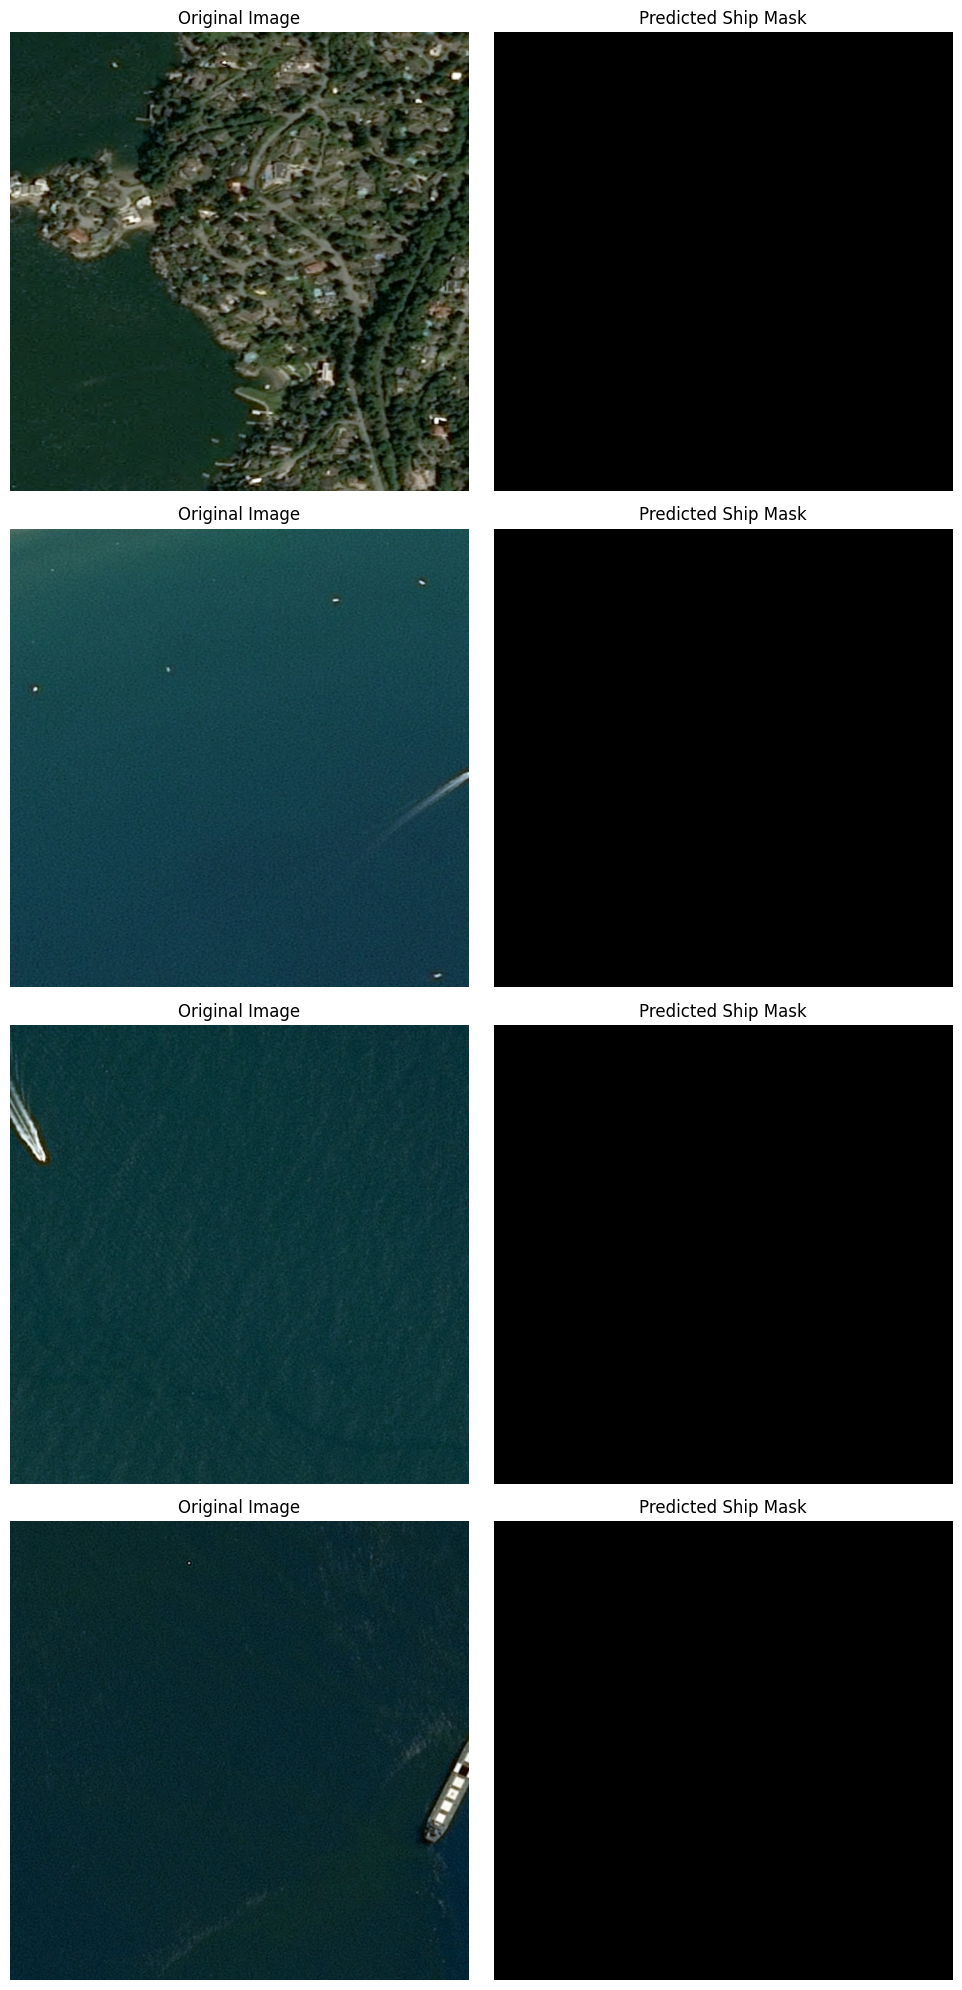

In [32]:
def plot_batch_predictions(batch, predictions):
    """
    Plot the images and their corresponding predictions for a batch.

    Args:
        batch (np.ndarray): Batch of preprocessed images.
        predictions (np.ndarray): Model predictions for the batch.
    """
    num_images = batch.shape[0]
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(batch[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Prediction
        predicted_mask = (predictions[i, :, :, 0] > 0.5).astype(np.uint8)  # Binarize the mask
        axes[i, 1].imshow(predicted_mask, cmap='gray')
        axes[i, 1].set_title("Predicted Ship Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Plot batch predictions
plot_batch_predictions(batch, predictions)